# FaceNet

## 1. Setup and Imports

In [1]:
import os
import pickle
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


dataset_path = "dataset"
val_size = 0.25
batch_size = 16
num_epochs = 30
learning_rate = 0.001
weight_decay = 1e-4
dropout_rate = 0.5
patience = 3 # For learning rate scheduler
final_model_path = "face_model.pkl"
best_model_path = "best_face_model.pkl"


# Force CPU usage
device = torch.device("cpu")
# To use GPU if available:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Initializing MTCNN (face detector)...")
# MTCNN for training (detects one face reliably)
mtcnn_train = MTCNN(image_size=160, margin=40, keep_all=False, thresholds=[0.6, 0.7, 0.7], min_face_size=40, device=device)
# MTCNN for testing (detects multiple faces)
mtcnn_test = MTCNN(image_size=160, margin=40, keep_all=True, thresholds=[0.4, 0.5, 0.6], min_face_size=15, device=device)

print("Initializing InceptionResnetV1 (FaceNet embeddings)...")
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
print("Models Initialized.")

Using device: cpu
Initializing MTCNN (face detector)...
Initializing InceptionResnetV1 (FaceNet embeddings)...
Models Initialized.


## 2. Data Preparation

In [2]:
# Enhanced Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(160, scale=(0.85, 1.15)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
])

# Validation transformations (minimal augmentation)
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
# Custom collate function to handle None values from MTCNN
def custom_collate_fn(batch):
    # Filter out None values (where face detection might have failed unexpectedly)
    batch = list(filter(lambda x: x is not None, batch))
    
    # If all elements are None after filtering, return empty tensors/lists
    if len(batch) == 0:
        return torch.Tensor([]).to(device), []
    
    # Separate images and labels
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Stack images into a batch tensor
    images = torch.stack(images, dim=0).to(device)
    
    return images, labels

# Dataset Class
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, mtcnn_model=None, device='cpu', preload=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.mtcnn = mtcnn_model
        self.device = device
        self.preload = preload
        self.preloaded_faces = {}
        self.valid_indices = []

        if self.mtcnn is None:
            raise ValueError("MTCNN model must be provided to FaceDataset")

        # Pre-process images to find valid faces and optionally preload
        print("Pre-processing images to detect faces...")
        for idx, img_path in tqdm(enumerate(self.image_paths), total=len(self.image_paths)):
            try:
                img = Image.open(img_path).convert('RGB')
                # Detect face using the provided MTCNN instance
                face = self.mtcnn(img)
                if face is not None:
                    self.valid_indices.append(idx)
                    if preload:
                        # Convert tensor to numpy for storage (saves GPU memory if preloading)
                        face_np = (face.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                        self.preloaded_faces[idx] = face_np
            except Exception as e:
                print(f"\nWarning: Error processing image {img_path}: {e}")
        
        print(f"Found {len(self.valid_indices)} valid faces out of {len(self.image_paths)} images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        true_idx = self.valid_indices[idx]
        img_path = self.image_paths[true_idx]
        label = self.labels[true_idx]
        
        face_np = None
        try:
            if self.preload and true_idx in self.preloaded_faces:
                face_np = self.preloaded_faces[true_idx]
            else:
                img = Image.open(img_path).convert('RGB')
                face_tensor = self.mtcnn(img) 
                
                if face_tensor is None:
                    print(f"\nWarning: Face detection failed for {img_path} during data loading (should have been pre-filtered). Skipping.")
                    # Return None to be filtered by collate_fn
                    return None
                
                # Convert tensor to numpy for transformation pipeline (ToPILImage expects numpy or PIL)
                face_np = (face_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            
            # Apply transformations
            if self.transform:
                face_tensor = self.transform(face_np) 
            else:
                # Basic transform if none provided
                face_tensor = transforms.ToTensor()(face_np)
            
            return face_tensor, label
            
        except Exception as e:
            print(f"\nError during __getitem__ for {img_path}: {e}")
            # Return None to be filtered by collate_fn
            return None

# Load Dataset Function
def load_dataset(dataset_path, val_size=0.25):
    image_paths, labels = [], []
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset directory '{dataset_path}' not found. CWD: {os.getcwd()}")
        
    class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"Found classes: {class_names}")
    if not class_names:
         raise ValueError(f"No subdirectories found in '{dataset_path}'. Each subdirectory should represent a class.")
         
    class_counts = {class_name: 0 for class_name in class_names}
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        image_count_in_class = 0
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(class_name) # Store class name as label
                image_count_in_class += 1
        
        class_counts[class_name] = image_count_in_class
        print(f"Class '{class_name}': {image_count_in_class} images")

    if len(image_paths) == 0:
        raise ValueError("No images found in the dataset directory. Check subfolders and image formats (.png, .jpg, .jpeg).")
    
    # Train-validation split
    train_images, val_images, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=val_size, random_state=42, stratify=labels
    )
    
    print(f"\nTotal images: {len(image_paths)}")
    print(f"Training set size: {len(train_images)}")
    print(f"Validation set size: {len(val_images)}")
    
    # Calculate class weights for handling imbalance
    class_weights = {}
    total_samples = len(train_labels) # Use training set size for weight calculation
    num_classes = len(class_names)
    
    # Recalculate counts based on the actual training split
    train_class_counts = {class_name: train_labels.count(class_name) for class_name in class_names}

    for class_name, count in train_class_counts.items():
        if count > 0:
            class_weights[class_name] = total_samples / (num_classes * count)
        else:
            # Assign a default weight if a class is not in the training set (shouldn't happen with stratify)
            class_weights[class_name] = 1.0 
            print(f"Warning: Class '{class_name}' has 0 samples in the training set.")
            
    print(f"Calculated class weights: {class_weights}")
    
    return train_images, train_labels, val_images, val_labels, class_names, class_weights

## 3. Model Definition

In [4]:
# Enhanced FaceClassifier Model with dropout and batch normalization
class FaceClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, dropout_rate=0.5):
        super(FaceClassifier, self).__init__()
        
        # First dense block
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.bn1 = nn.BatchNorm1d(512) # Batch Norm helps stabilize training
        self.dropout1 = nn.Dropout(dropout_rate) # Dropout reduces overfitting
        
        # Second dense block
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Input x is expected to be the embedding from FaceNet
        
        # First block
        x = self.fc1(x)
        # Apply BatchNorm only if batch size > 1, otherwise it throws an error
        if x.size(0) > 1:
             x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Second block
        x = self.fc2(x)
        if x.size(0) > 1:
             x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Output layer (Logits)
        # CrossEntropyLoss applies log_softmax internally, so no activation needed here
        x = self.fc3(x)
        
        return x

## 4. Training

In [5]:
# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader, criterion, device, label_map):
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    all_preds = []
    all_labels = []
    correct, total = 0, 0
    
    with torch.no_grad(): # Disable gradient calculations
        for images, labels in val_loader:
            if images.nelement() == 0: # Skip if batch is empty after collate_fn filtering
                continue
                
            images = images.to(device)
            # Convert string labels to numerical indices
            label_indices = torch.tensor([label_map[label] for label in labels]).to(device)
            
            # Get embeddings from FaceNet (pre-trained model)
            embeddings = facenet(images)
            # Get predictions from our classifier
            outputs = model(embeddings)
            
            # Calculate loss
            loss = criterion(outputs, label_indices)
            total_loss += loss.item() * images.size(0) # Accumulate weighted loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += label_indices.size(0)
            correct += (predicted == label_indices).sum().item()
            
            # Store predictions and true labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label_indices.cpu().numpy())
            
    # Calculate average loss and accuracy
    avg_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    
    return avg_loss, accuracy, all_preds, all_labels

In [6]:
try:
    train_images, train_labels, val_images, val_labels, class_names, class_weights = load_dataset(
        dataset_path, val_size=val_size
    )
    
    # Create mapping from class name to index
    label_map = {label: idx for idx, label in enumerate(class_names)}
    num_classes = len(class_names)

    # Create Dataset instances
    train_dataset = FaceDataset(train_images, train_labels, transform=train_transform, mtcnn_model=mtcnn_train, device=device)
    val_dataset = FaceDataset(val_images, val_labels, transform=val_transform, mtcnn_model=mtcnn_train, device=device)
    
    # Create DataLoader instances
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,
        collate_fn=custom_collate_fn,
        pin_memory=False # Set to True if using GPU and data fits memory
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        collate_fn=custom_collate_fn,
        pin_memory=False
    )

    # Create weight tensor for CrossEntropyLoss
    weight_tensor = torch.zeros(num_classes)
    for class_name, idx in label_map.items():
        weight_tensor[idx] = class_weights.get(class_name, 1.0) # Use calculated weight, default to 1.0 if missing
    weight_tensor = weight_tensor.to(device)
    print(f"Using loss weight tensor: {weight_tensor}")

except (FileNotFoundError, ValueError) as e:
    print(f"Error during data loading: {e}")
    raise e
    
model = FaceClassifier(embedding_dim=512, num_classes=num_classes, dropout_rate=dropout_rate).to(device)

# Use weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# AdamW optimizer with weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler: reduces LR if validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

best_val_accuracy = 0.0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train, total_train = 0, 0
    
    # Use tqdm for progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for images, labels in progress_bar:
        if images.nelement() == 0: # Skip empty batches
            continue
            
        images = images.to(device)
        label_indices = torch.tensor([label_map[label] for label in labels]).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get embeddings (no gradients needed for FaceNet)
        with torch.no_grad():
            embeddings = facenet(images)
        
        # Forward pass through classifier
        outputs = model(embeddings)
        
        # Calculate loss
        loss = criterion(outputs, label_indices)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += label_indices.size(0)
        correct_train += (predicted_train == label_indices).sum().item()
        
        # Update progress bar description
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct_train/total_train:.4f}" if total_train > 0 else "0.0000")
        
    # Calculate epoch training metrics
    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    epoch_val_loss, epoch_val_acc, _, _ = evaluate_model(model, val_loader, criterion, device, label_map)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Adjust learning rate based on validation loss
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
    print(f"  Current LR: {current_lr:.6f}")
    
    # Save the best model based on validation accuracy
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        model_data = {
            'model': model.state_dict(),
            'class_names': class_names,
            'label_map': label_map,
            'epoch': epoch,
            'val_acc': epoch_val_acc,
            'train_acc': epoch_train_acc
        }
        try:
            with open(best_model_path, "wb") as f:
                pickle.dump(model_data, f)
            print(f"---> New best model saved to {best_model_path} (Val Acc: {epoch_val_acc:.4f})")
        except Exception as e:
            print(f"Error saving best model: {e}")

print("\nTraining finished.")

# Save the final model state
final_model_data = {
    'model': model.state_dict(),
    'class_names': class_names,
    'label_map': label_map
}
try:
    with open(final_model_path, "wb") as f:
        pickle.dump(final_model_data, f)
    print(f"Final model state saved to {final_model_path}")
except Exception as e:
    print(f"Error saving final model: {e}")

Found classes: ['amisha', 'dhanoosh', 'jose', 'jui', 'ritvi', 'siddhangana', 'sparsh', 'yash']
Class 'amisha': 40 images
Class 'dhanoosh': 40 images
Class 'jose': 40 images
Class 'jui': 40 images
Class 'ritvi': 40 images
Class 'siddhangana': 40 images
Class 'sparsh': 40 images
Class 'yash': 40 images

Total images: 320
Training set size: 240
Validation set size: 80
Calculated class weights: {'amisha': 1.0, 'dhanoosh': 1.0, 'jose': 1.0, 'jui': 1.0, 'ritvi': 1.0, 'siddhangana': 1.0, 'sparsh': 1.0, 'yash': 1.0}
Pre-processing images to detect faces...


  0%|          | 0/240 [00:00<?, ?it/s]

Found 239 valid faces out of 240 images
Pre-processing images to detect faces...


  0%|          | 0/80 [00:00<?, ?it/s]

Found 79 valid faces out of 80 images
Using loss weight tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1.])

Starting training for 30 epochs...


c:\Users\Lenovo\anaconda3\envs\ee4228\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/30 Summary:
  Train Loss: 1.5915, Train Acc: 0.4686
  Val Loss:   1.9842, Val Acc:   0.2278
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.2278)


Epoch 2/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/30 Summary:
  Train Loss: 1.1094, Train Acc: 0.6736
  Val Loss:   1.7049, Val Acc:   0.4051
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.4051)


Epoch 3/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/30 Summary:
  Train Loss: 0.9104, Train Acc: 0.6904
  Val Loss:   1.1139, Val Acc:   0.8228
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.8228)


Epoch 4/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/30 Summary:
  Train Loss: 0.7340, Train Acc: 0.7615
  Val Loss:   0.6117, Val Acc:   0.8481
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.8481)


Epoch 5/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/30 Summary:
  Train Loss: 0.6737, Train Acc: 0.8033
  Val Loss:   0.4568, Val Acc:   0.8481
  Current LR: 0.001000


Epoch 6/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/30 Summary:
  Train Loss: 0.5940, Train Acc: 0.8117
  Val Loss:   0.3529, Val Acc:   0.8861
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.8861)


Epoch 7/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/30 Summary:
  Train Loss: 0.5540, Train Acc: 0.8452
  Val Loss:   0.3445, Val Acc:   0.8608
  Current LR: 0.001000


Epoch 8/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/30 Summary:
  Train Loss: 0.5857, Train Acc: 0.8159
  Val Loss:   0.3150, Val Acc:   0.8987
  Current LR: 0.001000
---> New best model saved to best_face_model.pkl (Val Acc: 0.8987)


Epoch 9/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/30 Summary:
  Train Loss: 0.5424, Train Acc: 0.8075
  Val Loss:   0.3281, Val Acc:   0.8987
  Current LR: 0.001000


Epoch 10/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/30 Summary:
  Train Loss: 0.5557, Train Acc: 0.8201
  Val Loss:   0.3490, Val Acc:   0.8861
  Current LR: 0.001000


Epoch 11/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/30 Summary:
  Train Loss: 0.5544, Train Acc: 0.7950
  Val Loss:   0.3192, Val Acc:   0.8861
  Current LR: 0.001000


Epoch 12/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/30 Summary:
  Train Loss: 0.4881, Train Acc: 0.8368
  Val Loss:   0.2856, Val Acc:   0.8987
  Current LR: 0.001000


Epoch 13/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/30 Summary:
  Train Loss: 0.4156, Train Acc: 0.8703
  Val Loss:   0.3349, Val Acc:   0.8734
  Current LR: 0.001000


Epoch 14/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/30 Summary:
  Train Loss: 0.4761, Train Acc: 0.8452
  Val Loss:   0.3421, Val Acc:   0.8608
  Current LR: 0.001000


Epoch 15/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/30 Summary:
  Train Loss: 0.5881, Train Acc: 0.7908
  Val Loss:   0.3354, Val Acc:   0.8734
  Current LR: 0.001000


Epoch 16/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/30 Summary:
  Train Loss: 0.5179, Train Acc: 0.8159
  Val Loss:   0.3182, Val Acc:   0.8861
  Current LR: 0.000500


Epoch 17/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/30 Summary:
  Train Loss: 0.4608, Train Acc: 0.8494
  Val Loss:   0.2701, Val Acc:   0.9241
  Current LR: 0.000500
---> New best model saved to best_face_model.pkl (Val Acc: 0.9241)


Epoch 18/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/30 Summary:
  Train Loss: 0.4458, Train Acc: 0.8661
  Val Loss:   0.2410, Val Acc:   0.9241
  Current LR: 0.000500


Epoch 19/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/30 Summary:
  Train Loss: 0.4440, Train Acc: 0.8285
  Val Loss:   0.2402, Val Acc:   0.9241
  Current LR: 0.000500


Epoch 20/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/30 Summary:
  Train Loss: 0.4119, Train Acc: 0.8452
  Val Loss:   0.2693, Val Acc:   0.9241
  Current LR: 0.000500


Epoch 21/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/30 Summary:
  Train Loss: 0.4909, Train Acc: 0.8452
  Val Loss:   0.2600, Val Acc:   0.9241
  Current LR: 0.000500


Epoch 22/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/30 Summary:
  Train Loss: 0.5080, Train Acc: 0.8243
  Val Loss:   0.2590, Val Acc:   0.9241
  Current LR: 0.000500


Epoch 23/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/30 Summary:
  Train Loss: 0.4834, Train Acc: 0.8452
  Val Loss:   0.2824, Val Acc:   0.9241
  Current LR: 0.000250


Epoch 24/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/30 Summary:
  Train Loss: 0.3576, Train Acc: 0.8828
  Val Loss:   0.2823, Val Acc:   0.9241
  Current LR: 0.000250


Epoch 25/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/30 Summary:
  Train Loss: 0.4555, Train Acc: 0.8452
  Val Loss:   0.2906, Val Acc:   0.9241
  Current LR: 0.000250


Epoch 26/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/30 Summary:
  Train Loss: 0.4201, Train Acc: 0.8912
  Val Loss:   0.2758, Val Acc:   0.9241
  Current LR: 0.000250


Epoch 27/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/30 Summary:
  Train Loss: 0.4294, Train Acc: 0.8494
  Val Loss:   0.2616, Val Acc:   0.9241
  Current LR: 0.000125


Epoch 28/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/30 Summary:
  Train Loss: 0.4414, Train Acc: 0.8536
  Val Loss:   0.2608, Val Acc:   0.9241
  Current LR: 0.000125


Epoch 29/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/30 Summary:
  Train Loss: 0.4067, Train Acc: 0.8745
  Val Loss:   0.2628, Val Acc:   0.9241
  Current LR: 0.000125


Epoch 30/30 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/30 Summary:
  Train Loss: 0.4604, Train Acc: 0.8536
  Val Loss:   0.2714, Val Acc:   0.9241
  Current LR: 0.000125

Training finished.
Final model state saved to face_model.pkl


## 5. Evaluation & Visualization

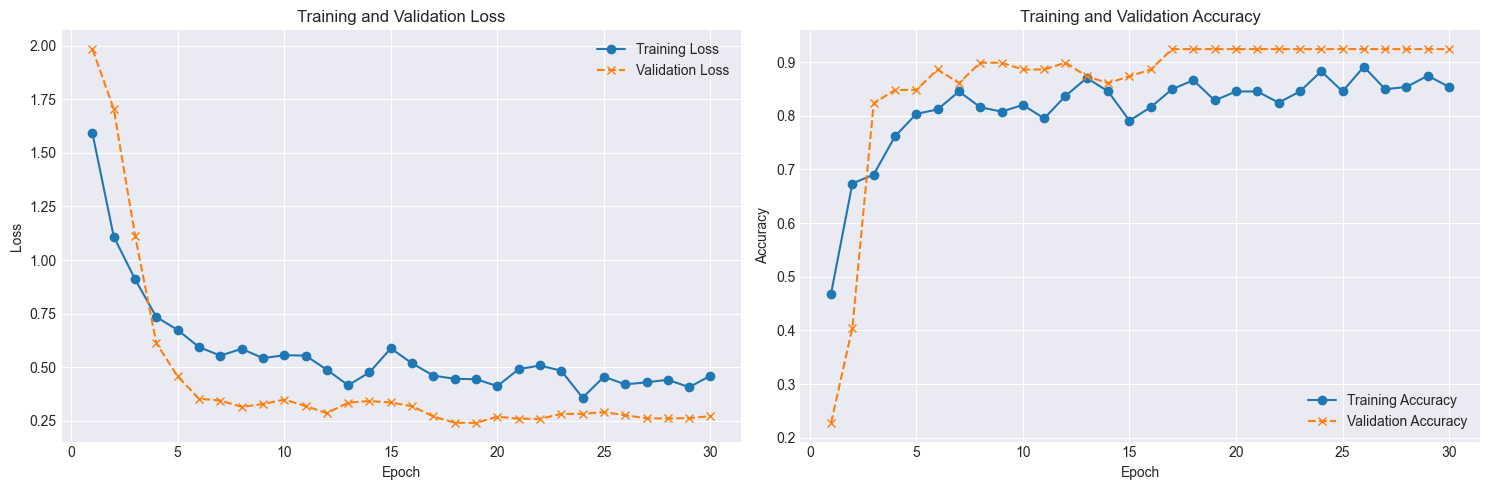


Evaluating the best saved model on the validation set...
Successfully loaded best model from epoch 16 with Val Acc: 0.9241
Best Model Validation -> Loss: 0.2701, Accuracy: 0.9241


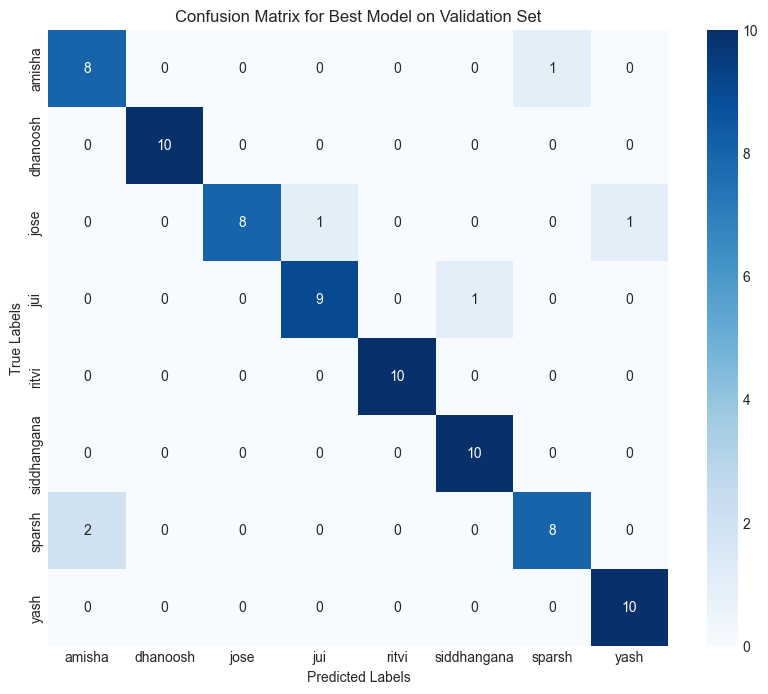

In [7]:
# Plot Training History
epochs_range = range(1, num_epochs + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(epochs_range, train_losses, label='Training Loss', marker='o', linestyle='-')
ax1.plot(epochs_range, val_losses, label='Validation Loss', marker='x', linestyle='--')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o', linestyle='-')
ax2.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='x', linestyle='--')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Evaluate Best Model and Show Confusion Matrix
print("\nEvaluating the best saved model on the validation set...")

# Load the best model saved during training
try:
    with open(best_model_path, "rb") as f:
        best_model_data = pickle.load(f)
    
    # Re-initialize model architecture and load state dict
    best_model = FaceClassifier(embedding_dim=512, num_classes=len(best_model_data['class_names']), dropout_rate=dropout_rate).to(device)
    best_model.load_state_dict(best_model_data['model'])
    loaded_class_names = best_model_data['class_names']
    loaded_label_map = best_model_data['label_map']
    print(f"Successfully loaded best model from epoch {best_model_data.get('epoch', 'N/A')} with Val Acc: {best_model_data.get('val_acc', 0.0):.4f}")

    # Evaluate the loaded best model
    best_val_loss, best_val_acc, val_preds_indices, val_true_indices = evaluate_model(
        best_model, val_loader, criterion, device, loaded_label_map
    )
    print(f"Best Model Validation -> Loss: {best_val_loss:.4f}, Accuracy: {best_val_acc:.4f}")

    # Generate and plot confusion matrix
    if val_preds_indices and val_true_indices:
        cm = confusion_matrix(val_true_indices, val_preds_indices)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=loaded_class_names, yticklabels=loaded_class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix for Best Model on Validation Set')
        plt.show()
    else:
        print("Could not generate confusion matrix: No validation predictions found.")

except FileNotFoundError:
    print(f"Error: Best model file '{best_model_path}' not found. Cannot evaluate or show confusion matrix.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the best model: {e}")



Evaluating the final saved model on the validation set...
Final Model Validation -> Loss: 0.2714, Accuracy: 0.9241


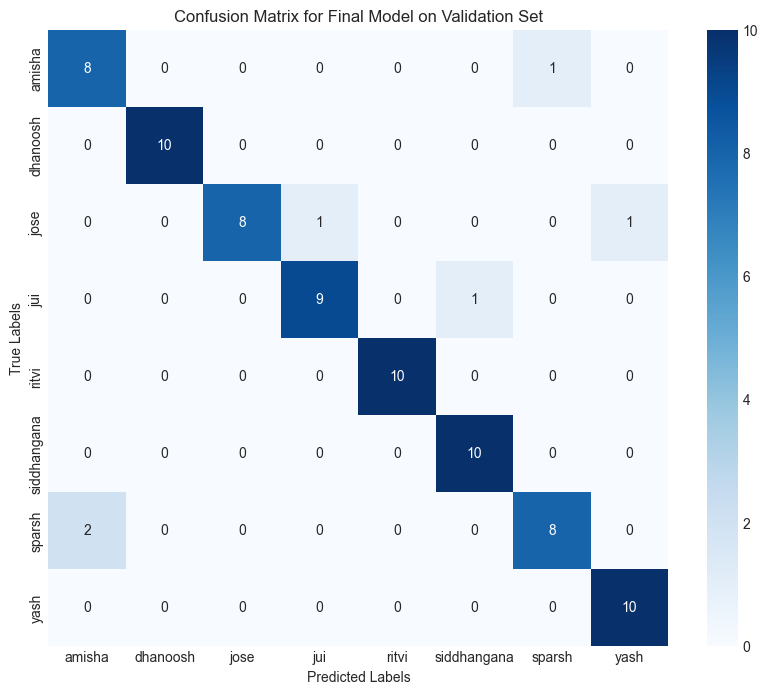

In [9]:
# Evaluate Final Model (last-epoch weights) and Show Confusion Matrix
print("\nEvaluating the final saved model on the validation set...")

# Load the final model saved during training
try:
    with open(final_model_path, "rb") as f:
        final_model_data = pickle.load(f)
    
    # Re-initialize model architecture and load state dict
    final_model = FaceClassifier(embedding_dim=512, num_classes=len(final_model_data['class_names']), dropout_rate=dropout_rate).to(device)
    final_model.load_state_dict(final_model_data['model'])
    loaded_class_names = final_model_data['class_names']
    loaded_label_map = final_model_data['label_map']

    # Evaluate the final saved model
    final_val_loss, final_val_acc, val_preds_indices, val_true_indices = evaluate_model(
        final_model, val_loader, criterion, device, loaded_label_map
    )
    print(f"Final Model Validation -> Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")

    # Generate and plot confusion matrix
    if val_preds_indices and val_true_indices:
        cm = confusion_matrix(val_true_indices, val_preds_indices)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=loaded_class_names, yticklabels=loaded_class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix for Final Model on Validation Set')
        plt.show()
    else:
        print("Could not generate confusion matrix: No validation predictions found.")

except FileNotFoundError:
    print(f"Error: Final model file '{final_model_path}' not found. Cannot evaluate or show confusion matrix.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the final model: {e}")
